In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

!cp /content/gdrive/MyDrive/HW5_train_val.zip /content/
!unzip HW5_train_val.zip

Mounted at /content/gdrive
Archive:  HW5_train_val.zip
 extracting: DIV2K_train_HR.zip      
 extracting: DIV2K_train_LR_bicubic_X4.zip  
 extracting: DIV2K_valid_HR.zip      
 extracting: DIV2K_valid_LR_bicubic_X4.zip  


In [2]:
!mkdir /content/valid_HR/
!mkdir /content/train_HR/

!mv DIV2K_train_HR.zip /content/train_HR/  
!mv DIV2K_valid_HR.zip /content/valid_HR/

!unzip /content/train_HR/DIV2K_train_HR.zip -d /content/train_HR/
!unzip /content/DIV2K_train_LR_bicubic_X4.zip -d /content/train_LR/
!unzip /content/valid_HR/DIV2K_valid_HR.zip -d /content/valid_HR/
!unzip /content/DIV2K_valid_LR_bicubic_X4.zip -d /content/valid_LR/


Archive:  /content/train_HR/DIV2K_train_HR.zip
   creating: /content/train_HR/DIV2K_train_HR/
  inflating: /content/train_HR/DIV2K_train_HR/0103.png  
  inflating: /content/train_HR/DIV2K_train_HR/0413.png  
  inflating: /content/train_HR/DIV2K_train_HR/0031.png  
  inflating: /content/train_HR/DIV2K_train_HR/0660.png  
  inflating: /content/train_HR/DIV2K_train_HR/0126.png  
  inflating: /content/train_HR/DIV2K_train_HR/0793.png  
  inflating: /content/train_HR/DIV2K_train_HR/0764.png  
  inflating: /content/train_HR/DIV2K_train_HR/0550.png  
  inflating: /content/train_HR/DIV2K_train_HR/0437.png  
  inflating: /content/train_HR/DIV2K_train_HR/0374.png  
  inflating: /content/train_HR/DIV2K_train_HR/0755.png  
  inflating: /content/train_HR/DIV2K_train_HR/0614.png  
  inflating: /content/train_HR/DIV2K_train_HR/0646.png  
  inflating: /content/train_HR/DIV2K_train_HR/0371.png  
  inflating: /content/train_HR/DIV2K_train_HR/0312.png  
  inflating: /content/train_HR/DIV2K_train_HR/0108.

In [2]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
cuda = torch.device('cuda')
cpu = torch.device('cpu')
device = cuda

In [3]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
train_dataset_LR = torchvision.datasets.ImageFolder(root='/content/train_LR/', transform=transforms.Compose([transforms.Resize([350,520]),transforms.ToTensor()]))#,normalize]))
train_dataset_HR = torchvision.datasets.ImageFolder(root='/content/train_HR/', transform=transforms.Compose([transforms.Resize([1400,2080]),transforms.ToTensor()]))#,normalize]))
dev_dataset_LR = torchvision.datasets.ImageFolder(root='/content/valid_LR/', transform=transforms.Compose([transforms.Resize([350,520]),transforms.ToTensor()]))#,normalize]))
dev_dataset_HR = torchvision.datasets.ImageFolder(root='/content/valid_HR/', transform=transforms.Compose([transforms.Resize([1400,2080]),transforms.ToTensor()]))#,normalize]))
#train_dataset_HR = torchvision.datasets.ImageFolder(root='/content/train_HR/',transform=transforms.ToTensor())


In [ ]:
transforms.Resize([224,224])

In [4]:
train_dataloader_HR = data.DataLoader(train_dataset_HR, num_workers=2, batch_size=16, shuffle=False, pin_memory=True)
dev_dataloader_HR = data.DataLoader(dev_dataset_HR, num_workers=2, batch_size=16, shuffle=False, pin_memory=True)
dev_dataloader_LR = data.DataLoader(dev_dataset_LR, num_workers=2, batch_size=16, shuffle=False, pin_memory=True)
train_dataloader_LR = data.DataLoader(train_dataset_LR, num_workers=2, batch_size=16, shuffle=False, pin_memory=True)

In [8]:
next(iter(train_dataloader_HR))[0].shape

torch.Size([16, 3, 1400, 2080])

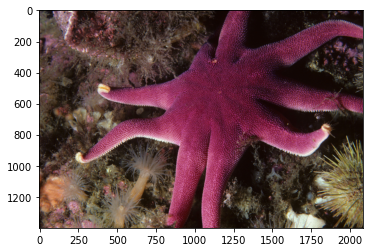

In [7]:
import matplotlib.pyplot as plt
img = next(iter(train_dataloader_HR))[0].numpy()[0]
#convert image back to Height,Width,Channels
img = np.transpose(img, (1,2,0))
#show the image
plt.imshow(img)
plt.show()  

In [69]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 2, stride=1, padding=2),
            nn.Tanh(),
            #nn.LeakyReLU(True),
            #nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 4, stride=2, padding=4),
            #nn.LeakyReLU(True),
            #nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 4, stride=2, padding=4),
            nn.Tanh(),
            nn.ConvTranspose2d(16, 3, 8, stride=4, padding=6),
            #nn.ReLU(True),
        )

    def forward(self, x):
        # x = self.conv(x)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

epoch [1/20], loss:0.0218


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [2/20], loss:0.0196
epoch [3/20], loss:0.0190
epoch [4/20], loss:0.0185
epoch [5/20], loss:0.0148
epoch [6/20], loss:0.0074
epoch [7/20], loss:0.0068
epoch [8/20], loss:0.0064
epoch [9/20], loss:0.0061
epoch [10/20], loss:0.0059


KeyboardInterrupt: ignored

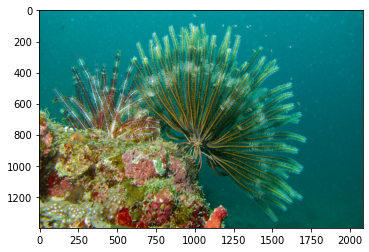

In [70]:



model = autoencoder().to(device)
criterion = nn.MSELoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 20
for epoch in range(num_epochs):
    total_loss = 0
    for batch, ((img,_),(hr,_))in enumerate(zip(train_dataloader_LR,train_dataloader_HR)):
        img = img.to(device)
        output = model(img)
        loss = criterion(output, hr.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    total_loss += loss.data
    scheduler.step(total_loss)
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, total_loss))
    if epoch % 10 == 0:
      plt.imshow(np.transpose(output.cpu().detach().numpy()[0], (1,2,0)))
      plt.imshow(np.transpose(hr.cpu().detach().numpy()[0], (1,2,0)))
      torch.save(model, "gdrive/MyDrive/model.pth")

In [78]:
img = next(iter(dev_dataloader_LR))[0]
hr = next(iter(dev_dataloader_HR))[0]

In [10]:
model = torch.load("/content/gdrive/MyDrive/model.pth")

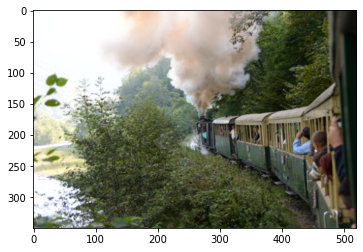

In [76]:
#show the image
import matplotlib.pyplot as plt
plt.imshow(np.transpose(img.cpu().detach().numpy()[0], (1,2,0)))
plt.show()  

In [79]:
output = model(img.to(device))

In [58]:
from torchvision.utils import save_image
save_image(output[0].cpu(), 'output.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


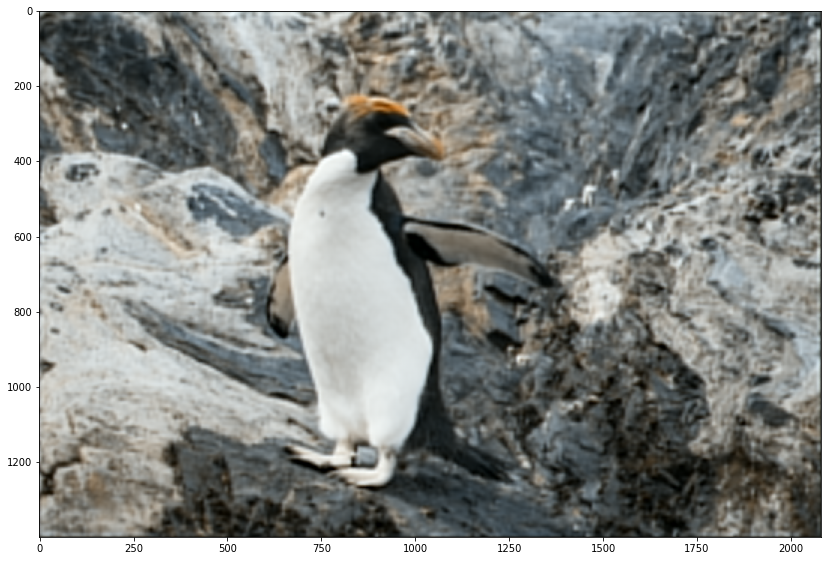

In [80]:
#show the output image
plt.figure(figsize=(14,20))
plt.imshow(np.transpose(output.cpu().detach().numpy()[0], (1,2,0)))
plt.show()
#plt.savefig("output.png")

In [32]:
output[0]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.6703, 1.7327,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.7173, 1.9720,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.6593, 1.9541,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 2.1081, 2.2316,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 1.9410, 2.0220,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 2.0500, 2.3031,  ..., 0.0000, 0.0000, 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


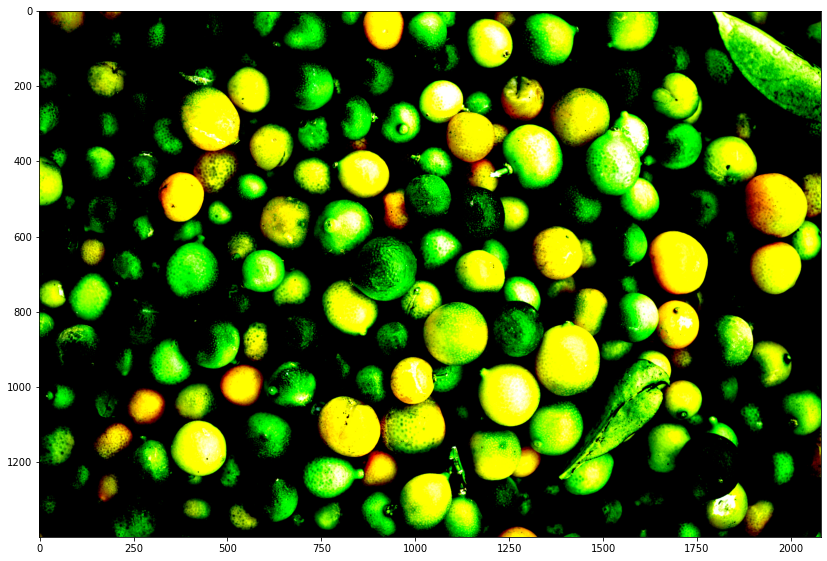

In [24]:
plt.figure(figsize=(14,20))
plt.imshow(np.transpose(hr.cpu().detach().numpy()[1], (1,2,0)))
plt.show() 

torch.Size([4, 3, 350, 520])
torch.Size([4, 16, 352, 522])
torch.Size([4, 8, 355, 525])


In [87]:
test = torch.randn((4,3,450,520))
print(test.shape)
test = nn.Conv2d(3, 16, 2,stride=1,padding=1)(test)
print(test.shape)
test = nn.Conv2d(16, 8, 4, stride=1, padding=2)(test)
print(test.shape)
test = nn.ConvTranspose2d(8, 16, 4, stride=2, padding=2)(test)
print(test.shape)
test = nn.ConvTranspose2d(16, 3, 6, stride=2, padding=4)(test)
print(test.shape)
del test

torch.Size([4, 3, 450, 520])
torch.Size([4, 16, 451, 521])
torch.Size([4, 8, 452, 522])
torch.Size([4, 16, 902, 1042])
torch.Size([4, 3, 1800, 2080])


In [ ]:
nn.Conv2d(3, 16, 2, stride=1, padding=2),
            nn.Tanh(),
            #nn.LeakyReLU(True),
            #nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 4, stride=2, padding=4),
            #nn.LeakyReLU(True),
            #nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 4, stride=2, padding=4),
            nn.Tanh(),
            nn.ConvTranspose2d(16, 3, 2, stride=4, padding=3),

In [47]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        self.conv4 = nn.Conv2d(8, 1, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(1)
        self.convt1 = nn.ConvTranspose2d(8, 8, 2, stride=2)
        self.convt2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.convt3 = nn.ConvTranspose2d(16, 8, 2, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        # Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                nn.init.normal_(m.bias.data)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        x = self.conv1(x)
        print(x.shape)
        x = self.pool(F.relu(self.bn1(x)))  # out [16, 104, 104, 1]
        print(x.shape)
        x = self.conv2(x)
        print(x.shape)
        x = self.pool(F.relu(self.bn2(x))) # out [8, 52, 52, 1]
        print(x.shape)
        x = self.conv3(x)
        print(x.shape)
        x = self.pool(F.relu(self.bn2(x))) # out [8, 26, 26, 1]
        print(x.shape)

        x = self.convt1(x)
        print(x.shape)
        x = F.relu(self.bn2(x)) # out [8, 52, 52, 1]
        print(x.shape)
        x = self.convt2(x)
        print(x.shape)
        x = F.relu(self.bn1(x)) # out [16, 104, 104, 1]
        print(x.shape)
        x = self.convt3(x)
        print(x.shape)
        x = F.relu(self.bn2(x)) # out [8, 208, 208, 1]
        print(x.shape)
        x = self.conv4(x)
        print(x.shape)
        x = self.bn4(x) # out [1, 208, 208, 1]
        print(x.shape)

        return None

In [49]:
model = autoencoder()

In [1]:
img = next(iter(train_dataloader_HR))[0]
img.shape

NameError: ignored

In [ ]:
model.forward(img)